Using Colab cache for faster access to the 'sis-text-class' dataset.
Готово данных: 139,957 отзывов
Баланс классов:
label
1    90675
0    49282
Name: count, dtype: int64

Устройство: cuda

Обучение началось...



Эпоха 1/8: 100%|██████████| 438/438 [02:52<00:00,  2.54it/s]


  Loss: 0.4990 | Val Accuracy: 0.7547
     Модель сохранена! Новый рекорд: 75.47%


Эпоха 2/8: 100%|██████████| 438/438 [02:51<00:00,  2.55it/s]


  Loss: 0.4280 | Val Accuracy: 0.7774
     Модель сохранена! Новый рекорд: 77.74%


Эпоха 3/8: 100%|██████████| 438/438 [02:52<00:00,  2.54it/s]


  Loss: 0.4019 | Val Accuracy: 0.7827
     Модель сохранена! Новый рекорд: 78.27%


Эпоха 4/8: 100%|██████████| 438/438 [02:52<00:00,  2.54it/s]


  Loss: 0.3864 | Val Accuracy: 0.7999
     Модель сохранена! Новый рекорд: 79.99%


Эпоха 5/8: 100%|██████████| 438/438 [02:51<00:00,  2.55it/s]


  Loss: 0.3708 | Val Accuracy: 0.7971


Эпоха 6/8: 100%|██████████| 438/438 [02:51<00:00,  2.55it/s]


  Loss: 0.3576 | Val Accuracy: 0.8029
     Модель сохранена! Новый рекорд: 80.29%


Эпоха 7/8: 100%|██████████| 438/438 [02:51<00:00,  2.55it/s]


  Loss: 0.3469 | Val Accuracy: 0.8068
     Модель сохранена! Новый рекорд: 80.68%


Эпоха 8/8: 100%|██████████| 438/438 [02:52<00:00,  2.55it/s]


  Loss: 0.3365 | Val Accuracy: 0.8051

ФИНАЛЬНЫЙ РЕЗУЛЬТАТ
Точность на тестовой выборке: 0.8068 (80.68%)
               precision    recall  f1-score   support

Отрицательный       0.79      0.62      0.69      9857
Положительный       0.81      0.91      0.86     18135

     accuracy                           0.81     27992
    macro avg       0.80      0.76      0.78     27992
 weighted avg       0.80      0.81      0.80     27992



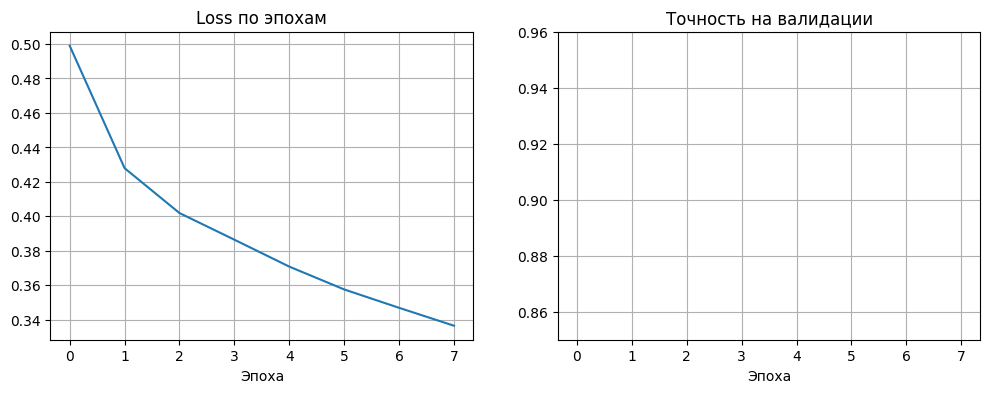


Примеры предсказаний:
('Положительный', 0.9995)
('Отрицательный', 0.0032)
('Отрицательный', 0.0029)


In [4]:
!pip install -q kagglehub tqdm matplotlib seaborn

import kagglehub, os, pandas as pd, numpy as np, re, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from tqdm import tqdm
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

path = kagglehub.dataset_download("senylar/sis-text-class")
df = pd.read_csv(os.path.join(path, "train.csv"))

df = df[df['sentiment'].isin([0, 1])].copy()
df = df[['text', 'sentiment']].dropna().reset_index(drop=True)
df.rename(columns={'sentiment': 'label'}, inplace=True)

def clean_text(t):
    t = re.sub(r'[^а-яё]', ' ', str(t).lower())
    t = re.sub(r'\s+', ' ', t).strip()
    return t

df['text'] = df['text'].apply(clean_text)
df = df[df['text'].str.len() > 15].reset_index(drop=True)

print(f"Готово данных: {len(df):,} отзывов")
print(f"Баланс классов:\n{df['label'].value_counts()}")

MAX_VOCAB = 25000
MAX_LEN = 120

all_words = ' '.join(df['text']).split()
vocab = ['<PAD>', '<UNK>'] + [w for w, _ in Counter(all_words).most_common(MAX_VOCAB)]
word2idx = {w: i for i, w in enumerate(vocab)}

def text_to_seq(text):
    seq = [word2idx.get(w, 1) for w in text.split()[:MAX_LEN]]
    seq += [0] * (MAX_LEN - len(seq))
    return seq

X = np.array(df['text'].apply(text_to_seq).tolist())
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

batch_size = 256 if torch.cuda.is_available() else 128
train_loader = DataLoader(ReviewDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(ReviewDataset(X_test,  y_test),  batch_size=batch_size)

class AdvancedRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=384, n_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers,
                            batch_first=True, dropout=0.5, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.6)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        emb = self.dropout(self.embedding(x))
        lstm_out, (h, c) = self.lstm(emb)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.dropout(context)
        return self.sig(self.fc(out))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nУстройство: {device}")

model = AdvancedRNN(len(vocab)).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5)

best_acc = 0
history = {'loss': [], 'val_acc': []}

print("\nОбучение началось...\n")
for epoch in range(8):
    model.train()
    epoch_loss = 0
    for texts, labels in tqdm(train_loader, desc=f"Эпоха {epoch+1}/8"):
        texts, labels = texts.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()

    model.eval()
    val_preds = []
    with torch.no_grad():
        for texts, _ in test_loader:
            preds = model(texts.to(device))
            val_preds.extend(preds.cpu().numpy().flatten())

    val_acc = accuracy_score(y_test, (np.array(val_preds) > 0.5))

    history['loss'].append(epoch_loss / len(train_loader))
    history['val_acc'].append(val_acc)
    scheduler.step(epoch_loss)

    print(f"  Loss: {history['loss'][-1]:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_rnn_sentiment.pth")
        print(f"     Модель сохранена! Новый рекорд: {best_acc:.2%}")

model.load_state_dict(torch.load("best_rnn_sentiment.pth"))
model.eval()
final_preds = []
with torch.no_grad():
    for texts, _ in test_loader:
        preds = model(texts.to(device))
        final_preds.extend((preds.cpu() > 0.5).numpy().flatten())

final_accuracy = accuracy_score(y_test, final_preds)
print(f"\nФИНАЛЬНЫЙ РЕЗУЛЬТАТ")
print(f"Точность на тестовой выборке: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print(classification_report(y_test, final_preds, target_names=['Отрицательный', 'Положительный']))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'])
plt.title('Loss по эпохам')
plt.xlabel('Эпоха')
plt.grid()

plt.subplot(1,2,2)
plt.plot(history['val_acc'], color='green')
plt.title('Точность на валидации')
plt.xlabel('Эпоха')
plt.ylim(0.85, 0.96)
plt.grid()
plt.show()

def predict_review(text):
    model.eval()
    cleaned = clean_text(text)
    seq = text_to_seq(cleaned)
    tensor = torch.LongTensor([seq]).to(device)
    with torch.no_grad():
        prob = model(tensor).cpu().item()
    sentiment = "Положительный" if prob > 0.5 else "Отрицательный"
    return sentiment, round(prob, 4)

print("\nПримеры предсказаний:")
print(predict_review("Отличный товар, быстро доставили, рекомендую!"))
print(predict_review("Ужасный сервис, никогда больше не обращусь"))
print(predict_review("Обычный телефон, ничего особенного"))